In [ ]:
import pandas as pd

df = pd.read_csv('dataset/systhetic_logs.csv')
df

In [ ]:
df.source.unique()

In [ ]:
df.target_label.unique()

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

model = SentenceTransformer('all=MiniLM-L6-v2')

embeddings = model.encode(df['log_message'].tolist())
embeddings[:2]

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=1, metric='cosine')
clusters = dbscan.fit_predict(embeddings)

df['cluster'] = clusters
df.head()

In [ ]:
cluster_counts = df['cluster'].value_counts()
large_clusters = cluster_counts[cluster_counts > 10].index

for cluster in large_clusters:
    print(f"cluster {cluster}:")
    print(df[df['cluster'] == cluster]['log_message'].head(5).to_string(index=False))
    print()

In [ ]:
import re
def classify_with_regex(log_message):
    regex_patterns = {
        r"User User\d+ logged (in|out).": "User Action",
        r"Backup (started|ended) at .*": "System Notification",
        r"Backup completed succesfully.": "System Notification",
        r"System updated to version .*": "System Notification",
        r"File .* uploaded succesfully by user .*": "System Notification",
        r"Disk cleanup completed succesfully.": "System Notification",
        r"System reboot initiated by user .*": "System Notification",
        r"Acoount with ID .* created by .*": "User Action"
    }
    for pattern, label in regex_patterns.items():
        if re.search(pattern, log_message, re.IGNORECASE):
            return label
    return "Other"

In [ ]:
classify_with_regex("User User494 logged OUT")

In [ ]:
df['regex_label'] = df['log_message'].apply(classify_with_regex)
df[df.regex_label.notnull()]

In [ ]:
## Have to use BERT/LLM for these

df_non_regex = df[df['regex_label'].isnull()].copy()
df_non_regex

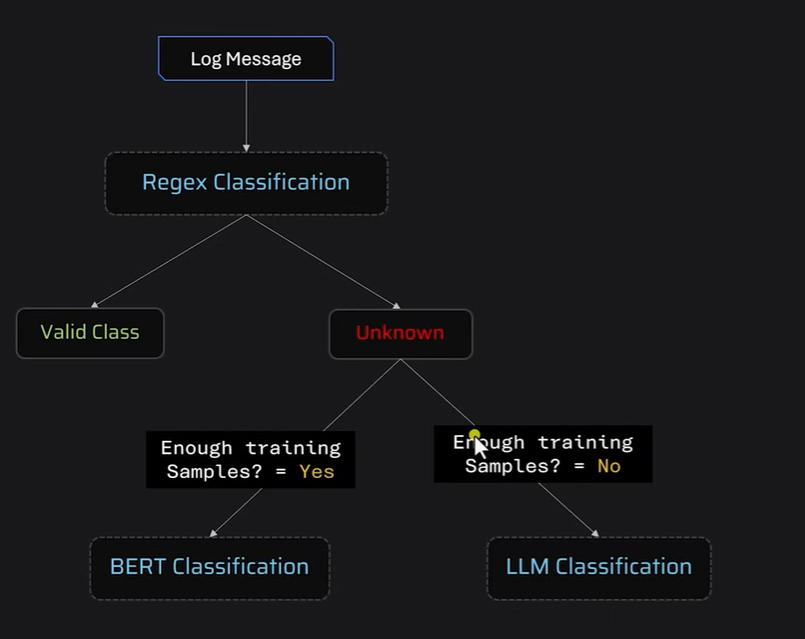

In [ ]:
print(df_non_regex['target_label'].value_counts()[df_non_regex['target_label'].value_counts() <= 5].index.to_list())


In [ ]:
df_non_legacy = df_non_regex[df_non_regex.source != 'LegacyCRM']
df_non_legacy.source.unique()

In [ ]:
filtered_embeddings = model.encode(df['log_message'].to_list())
filtered_embeddings[:2]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

X = filtered_embeddings
y = df_non_legacy['target_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf,predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
import joblib
joblib.dump(clf, 'models/log_classifier.joblib')